In [7]:
import pandas as pd

import pandas as pd

# My first step is to load the dataset. I'm using pandas, which is perfect for this.
# I put the CSV file in the same folder to make it easy to find.
try:
    df = pd.read_csv('/home/nashtech/Documents/Tesla.csv')
except FileNotFoundError:
    print("Whoops! I need to download the Tesla Stock Data from Kaggle first.")
    # I can grab the dataset from here: https://www.kaggle.com/datasets/rpaguirregabiria/tesla-stock-data-updated-till-2023
    exit()

# Let's take a quick peek at the first few rows to see what I'm working with.
print("Here's a sample of the data:")
print(df.head())

# I'll also use .info() to check the data types and see if any data is missing.
print("\nAnd here's the info on my columns:")
df.info()

Here's a sample of the data:
        Date       Open   High        Low      Close    Volume  Adj Close
0  6/29/2010  19.000000  25.00  17.540001  23.889999  18766300  23.889999
1  6/30/2010  25.790001  30.42  23.299999  23.830000  17187100  23.830000
2   7/1/2010  25.000000  25.92  20.270000  21.959999   8218800  21.959999
3   7/2/2010  23.000000  23.10  18.709999  19.200001   5139800  19.200001
4   7/6/2010  20.000000  20.00  15.830000  16.110001   6866900  16.110001

And here's the info on my columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64

In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# For this project, I'm just going to focus on predicting the 'Open' price.
# I'll grab that column and reshape it.
data = df['Open'].values.reshape(-1, 1)

# Neural networks like numbers to be in a small range, so I'll scale everything
# to be between 0 and 1. This helps the model train better.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# This is the core part of prepping time-series data. I need to create "windows"
# or sequences. This function will take the last 60 days of data as an input (X)
# and the next day's price as the output to predict (y).
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# I've decided to use a sequence length of 60 days.
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# LSTMs in Keras need the input data in a specific 3D shape:
# [number of samples, number of time steps, number of features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Now I'll split my data. It's super important NOT to shuffle time-series data.
# I need to train on the past and test on the more recent future.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
from tensorflow.keras.models import Sequential
# Import the Input layer
from tensorflow.keras.layers import Input, LSTM, Dense

# I'm using a Sequential model, which is like building a Lego tower, layer by layer.
model = Sequential()

# Adding an explicit Input layer first to define the shape of my data.
#    It tells the model: "Expect data that looks like this."
model.add(Input(shape=(X_train.shape[1], 1)))

# Now, I am adding the LSTM layer, but WITHOUT the input_shape argument,
#    since the model already knows the input shape from the layer above.
model.add(LSTM(units=50, return_sequences=True))

# Here's my second LSTM layer (this one doesn't change).
model.add(LSTM(units=50))

# And finally, a Dense layer with one neuron will give me my single predicted price.
model.add(Dense(units=1))

# Now I compile the model, telling it what optimizer and loss function to use.
# 'adam' and 'mean_squared_error' are pretty standard and effective for this kind of problem.
model.compile(optimizer='adam', loss='mean_squared_error')

# Let's print a summary to see the architecture I just built.
# You'll now see the InputLayer listed at the top!
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Here we go! I'm training the model on my training data.
# I'll run it for 50 epochs, with a batch size of 32.
# I'm also passing my test set as validation_data so I can watch how it performs on unseen data during training.
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0337 - val_loss: 0.0060
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.8919e-04 - val_loss: 0.0018
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.1467e-04 - val_loss: 0.0016
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.2416e-04 - val_loss: 0.0017
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
My Mean Absolute Error (MAE) is: 4.71651344223349
My Root Mean Squared Error (RMSE) is: 6.2190636105275905


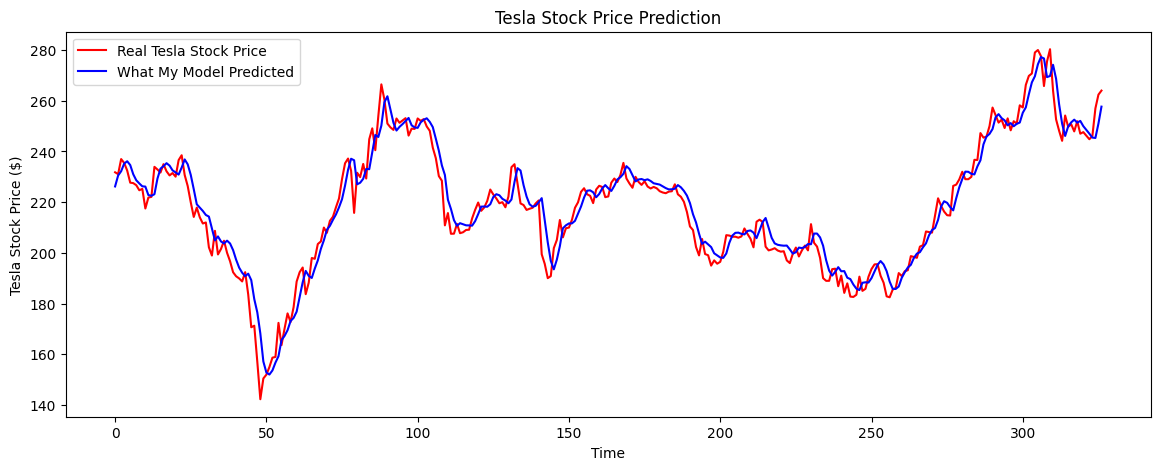

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Let's get the model's predictions on the test set.
predictions = model.predict(X_test)

# The predictions are scaled between 0 and 1, so I need to inverse the scaling
# to get them back into actual dollar amounts. I'll do this for both my
# predictions and the actual test values so I can compare them.
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Now, I'll calculate the MAE and RMSE to quantify the error.
mae = mean_absolute_error(y_test_scaled, predictions)
rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions))

print(f"My Mean Absolute Error (MAE) is: {mae}")
print(f"My Root Mean Squared Error (RMSE) is: {rmse}")

# A picture is worth a thousand words. Let's plot the actual vs. predicted prices.
plt.figure(figsize=(14,5))
plt.plot(y_test_scaled, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(predictions, color = 'blue', label = 'What My Model Predicted')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price ($)')
plt.legend()
plt.show()